In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import warnings
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

warnings.filterwarnings("ignore")

from sklearn.model_selection import StratifiedKFold


In [3]:
train_df = pd.read_csv('train.csv', index_col = 'id')
test_df = pd.read_csv('test.csv', index_col = 'id')
secondary = pd.read_csv('secondary_data.csv', sep = ';')
tertiary = pd.read_csv('one_million_mushrooms.csv', sep = ';')
# tertiary_test = pd.read_csv('tertiary_data_2.csv', sep = ';') # ? Intended as test data but could be used for training?

In [4]:
train_df = pd.concat([train_df, secondary, tertiary], ignore_index=True)

In [5]:
train_df

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,e,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.88,f,y,g,f,s,NaN,g,4.16,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.85,x,l,w,f,d,NaN,w,3.37,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4216009,p,7.03,f,d,e,t,d,c,y,5.83,...,NaN,NaN,e,NaN,NaN,f,f,NaN,d,u
4216010,e,4.92,x,NaN,w,f,x,c,n,7.02,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
4216011,p,8.68,x,d,e,t,d,c,w,8.98,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
4216012,p,8.08,f,d,e,t,d,c,w,6.32,...,NaN,NaN,e,NaN,NaN,f,f,NaN,d,a


In [6]:
features = train_df.drop('class', axis = 1).columns.tolist()

In [7]:
features_with_high_null_values = [feature for feature in features if (train_df[feature].isna().sum()/len(train_df) * 100) > 20]
features_with_high_null_values

['cap-surface',
 'gill-spacing',
 'stem-root',
 'stem-surface',
 'veil-type',
 'veil-color',
 'spore-print-color']

In [8]:
categorical_features = train_df[features].select_dtypes(include = 'object').columns.tolist()
numerical_features = list(set(features) - set(categorical_features))

In [9]:
def cleaner(df, cols_to_filter):

    features_dict = {
        'cap_shape': ['x', 'f', 's', 'b', 'o', 'p', 'c'],
        'cap_surface': ['t', 's', 'y', 'h', 'g', 'd', 'k', 'e', 'i', 'w', 'l'],
        'cap_color': ['n', 'y', 'w', 'g', 'e', 'o', 'p', 'r', 'u', 'b', 'k', 'l'],
        'does_bruise_or_bleed': ['f', 't'],
        'gill_attachment': ['a', 'd', 'x', 'e', 's', 'p', 'f'],
        'gill_spacing': ['c', 'd', 'f'],
        'gill_color': ['w', 'n', 'y', 'p', 'g', 'o', 'k', 'f', 'r', 'e', 'b', 'u'],
        'stem_root': ['b', 's', 'r', 'c', 'f'],
        'stem_surface': ['s', 'y', 'i', 't', 'g', 'k', 'h', 'f'],
        'stem_color': ['w', 'n', 'y', 'g', 'o', 'e', 'u', 'p', 'k', 'r', 'l', 'b', 'f'],
        'veil_type': ['u'],
        'veil_color': ['w', 'y', 'n', 'u', 'k', 'e'],
        'has_ring': ['f', 't'],
        'ring_type': ['f', 'e', 'z', 'l', 'r', 'p', 'g', 'm'],
        'spore_print_color': ['k', 'p', 'w', 'n', 'r', 'u', 'g'],
        'habitat': ['d', 'g', 'l', 'm', 'h', 'w', 'p', 'u'],
        'season': ['a', 'u', 'w', 's']
    }
    
    for classes, cols  in zip(features_dict.keys(), cols_to_filter):
        df.loc[~df[cols].isin(features_dict[classes]), cols] = "missing"
        df[cols] = df[cols].astype('category')

    return df

In [10]:
def feature_engineering(df):
    df['stem-area'] = df['stem-height'] * df['stem-width']
    return df

In [11]:
train_df = cleaner(train_df, categorical_features)
test_df = cleaner(test_df, categorical_features)

In [12]:
# train_df = feature_engineering(train_df)
# test_df = feature_engineering(test_df)

In [13]:
knn_imputer = KNNImputer(n_neighbors = 3) # KNN imputer uses other numerical features to find values for the missing values

train_df['cap-diameter'] = knn_imputer.fit_transform(train_df[['cap-diameter']]) 
test_df['cap-diameter'] = knn_imputer.transform(test_df[['cap-diameter']])

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4216014 entries, 0 to 4216013
Data columns (total 21 columns):
 #   Column                Dtype   
---  ------                -----   
 0   class                 object  
 1   cap-diameter          float64 
 2   cap-shape             category
 3   cap-surface           category
 4   cap-color             category
 5   does-bruise-or-bleed  category
 6   gill-attachment       category
 7   gill-spacing          category
 8   gill-color            category
 9   stem-height           float64 
 10  stem-width            float64 
 11  stem-root             category
 12  stem-surface          category
 13  stem-color            category
 14  veil-type             category
 15  veil-color            category
 16  has-ring              category
 17  ring-type             category
 18  spore-print-color     category
 19  habitat               category
 20  season                category
dtypes: category(17), float64(3), object(1)
memory usage: 1

In [14]:
from sklearn.preprocessing import LabelEncoder

X = train_df.copy()
y = X.pop('class')

lab_enc = LabelEncoder().fit(y)
y = lab_enc.transform(y)

In [15]:
skfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state=42)

In [16]:
for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
    print(f"train_index {len(train_idx)}")
    print(f"test_index {len(test_idx)}")


train_index 3372811
test_index 843203
train_index 3372811
test_index 843203
train_index 3372811
test_index 843203
train_index 3372811
test_index 843203
train_index 3372812
test_index 843202


In [17]:


def model_report(estimator, X, y, cv = 5):
    print('='*80)
    print(f"     Model: {estimator.__class__.__name__}")
    print('='*80)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 1/cv, shuffle = True, stratify = y, random_state = 42)

    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"F1 Score : {f1.mean():.6f}")
    print(f"MCC Score : {mcc.mean():.6f}")

    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title('Confusion Matrix')
    plt.show()

    print()


In [18]:
def model_report_Kfold(estimator, X, y, n_splits = 5, random_state = 42):

    mccs = []

    skfold = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state=random_state)
    print('='*80)
    print(f"     Model: {estimator.__class__.__name__}")
    print('='*80)

    for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
        X_train, y_train = X.iloc[train_idx, :], y[train_idx]
        X_test, y_test = X.iloc[test_idx, :], y[test_idx]

        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        mcc = matthews_corrcoef(y_pred, y_test)
        mccs.append(mcc)
        print(f"Fold {fold} MCC Score : {mcc}")

    print(f"Overall MCC : {np.mean(mccs)}")



In [19]:
def model_trainer(model, X, y, n_splits = 5, random_state = 42):
    skfold = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = random_state)
    oof_probs, oof_mccs = [], []
    print('='*80)
    print(f"Training {model.__class__.__name__}")
    print('='*80, end = '\n')

    for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
        X_train, y_train = X.iloc[train_idx, :], y[train_idx]
        X_test, y_test = X.iloc[test_idx, :], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mcc = matthews_corrcoef(y_pred, y_test)
        oof_mccs.append(mcc)
        oof_probs.append(model.predict_proba(test_df))

        print(f"--- Fold {fold + 1} MCC Score: {mcc:.6f}")
        print(f"\n---> Mean MCC Score: {np.mean(oof_mccs):.6f} \xb1 {np.std(oof_mccs):.6f}\n\n")
    return oof_probs, oof_mccs

In [20]:
def model_trainer_tts(model, X, y, random_state = 42):

    oof_probs, oof_mccs = [],[]

    print('='*80)
    print(f"Training {model.__class__.__name__}")
    print('='*80)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=random_state)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mcc = matthews_corrcoef(y_pred, y_test)
    oof_mccs.append(mcc)

    model.fit(X, y) # full dataset?

    oof_probs.append(model.predict_proba(test_df))

    print(f'MCC Score : {mcc}')
    
    return oof_probs, oof_mccs

     Model: LGBMClassifier
F1 Score : 0.993656
MCC Score : 0.985944


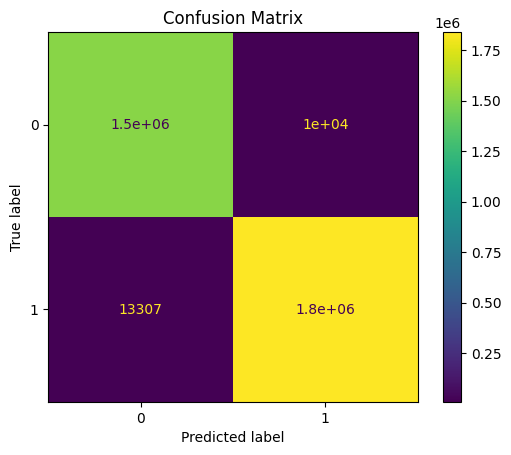

In [21]:
lgbm_clf = LGBMClassifier(device = 'gpu', verbosity = -1)

model_report(lgbm_clf, X, y)

In [22]:
# best_params_xgb = {'n_estimators': 2462,
#                     'eta': 0.009989840440188042,
#                     'gamma': 0.2773754955909051,
#                     'max_depth': 22,
#                     'min_child_weight': 54,
#                     'subsample': 0.9384639385648993,
#                     'colsample_bytree': 0.44310344610018826,
#                     'grow_policy': 'lossguide',
#                     'max_leaves': 81}


# best_params_xgb = {'n_estimators': 2369, 
#                    'eta': 0.009481956349357074, 
#                    'gamma': 0.10893509090507081, 
#                    'max_depth': 16, 
#                    'min_child_weight': 43, 
#                    'alpha': 0.2481084743547757, 
#                    'lambda': 0.2828029678929547, 
#                    'subsample': 0.9797614802453704, 
#                    'colsample_bytree': 0.4176757363547006}

# * LIGHTGBM GBDT



In [23]:
# f, _ = model_trainer_tts(
# ), X, y)


In [24]:
# preds = lab_enc.inverse_transform(np.argmax(np.mean(f, axis = 0),axis = 1))
# sub = pd.read_csv('sample_submission.csv')
# sub['class'] = preds

In [25]:
# sub.to_csv('version_12_submission.csv', index = False)

Notes

In [26]:

# * MCC Score : 0.983147
# * MCC Score : 0.983182 ; noise is converted to missing
# * MCC Score : 0.983182 ; no difference in managing missing values
# * MCC Sore : 0.982143 ; leave np.nans and one hot encoding
# * MCC Score : 0.983161 ; leave np.nans
# * MCC Score : 0.983182 ; noise converted to missing ; KNN Imputer
# * MCC Score : 0.983123 ;  noise converted to missing ; KNN Imputer ; tree_method = 'approx'
# * MCC Score : 0.983062 ;  noise converted to missing ; feature engineering added stem-area
# * MCC Score : 0.983526 ; noise converted to missing ; added secondary data
# * MCC Score : 0.987624 ; noise converted to missing ; added secondary data ; added tertiary data
# * MCC Score : 0.988943 ; noise converted to missing ; added secondary data ; added tertiary data ; added tertiary2 data
# * MCC Score : 0.988451 ; noise converted to missing ; added secondary data ; added tertiary data ; best parameters after optuna hyperparameter tuning

Hyperparameter Tuning

In [27]:
# import optuna
# from optuna.samplers import TPESampler

In [28]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.2, shuffle = True, stratify = y, random_state = 42)

In [29]:
# def objective(trial):
#     params = {
#         "n_estimators" : trial.suggest_int('n_estimators', 2000, 3000),
#         'eta' : trial.suggest_float("eta", 1e-3, 1e-2),
#         'gamma' : trial.suggest_float("gamma", 0, 5.0),
#         'max_depth' : trial.suggest_int("max_depth", 2, 32),
#         'min_child_weight' : trial.suggest_int("min_child_weight", 40, 100),
#         'subsample' : trial.suggest_float('subsample', 0.1, 1.0),
#         'colsample_bytree' : trial.suggest_float("colsample_bytree", 0.1, 1.0),
#         'grow_policy' : trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
#         'max_leaves' : trial.suggest_int("max_leaves", 16, 84),
        
#         'device' : 'cuda',
#         'tree_method' : 'hist',
#         'enable_categorical' : True,
#     }

    
#     model = XGBClassifier(**params)
#     model.fit(X_train, y_train)

#     y_pred = model.predict(X_test)
#     return matthews_corrcoef(y_test, y_pred)

# study_name = 'xgb'
# storage = 'sqlite:///xgb.db'

# study = optuna.create_study(storage = storage,
#                                 study_name = study_name,
#                                 direction = "maximize",
#                                 sampler = TPESampler(),
#                                 load_if_exists=True)

# study.optimize(objective, n_trials = 100)

# print(study.best_params)


# ? Best Parameters : {'n_estimators': 2462, 'eta': 0.009989840440188042, 'gamma': 0.2773754955909051, 'max_depth': 22, 'min_child_weight': 54, 'subsample': 0.9384639385648993, 'colsample_bytree': 0.44310344610018826, 'grow_policy': 'lossguide', 'max_leaves': 81}

In [30]:
# pipeline = XGBClassifier(enable_categorical = True, device = 'cuda', tree_method = 'gpu_hist', **best_params_xgb)

# f, _ = model_trainer(pipeline, X, y)
# preds = np.argmax(np.mean(f, axis = 0), axis = 1)
# sub = pd.read_csv('sample_submission.csv')
# sub['class'] = lab_enc.inverse_transform(preds)
# sub.to_csv('version_12_submission.csv', index = False)

In [31]:
# from lightgbm import LGBMClassifier

# lgb_clf = LGBMClassifier(device = 'gpu', verbosity = -1)

# model_report(lgb_clf, X, y)

In [32]:
xgb_params = {
    'n_estimators': 2407,
    'eta': 0.009462133032592785,
    'gamma': 0.2865859948765318,
    'max_depth': 31,
    'min_child_weight': 47,
    'subsample': 0.6956431754146083,
    'colsample_bytree': 0.3670732604094118,
    'grow_policy': 'lossguide',
    'max_leaves': 73,
    'enable_categorical': True,
    'n_jobs': -1,
    'device': 'cuda',
    'tree_method': 'hist'
} # 0.9844272567086021

cat_params = {
    'iterations': 1041,
    'learning_rate': 0.08777255350163136,
    'depth': 10,
    'l2_leaf_reg': 0.1259643500248322,
    'bootstrap_type': 'Bayesian',
    'random_strength': 4.276181166674371e-08,
    'bagging_temperature': 0.35995482350907326,
    'od_type': 'Iter',
    'od_wait': 39,
    "verbose": False,
    "allow_writing_files": False,
    "task_type": 'GPU',
    "cat_features": categorical_features
} # 0.9841773055825763

lgb_params = {
    'n_estimators': 2500,
    'random_state':42,
    'max_bin':1024,
    'colsample_bytree':0.6,
    'reg_lambda': 80,
    # 'device': 'gpu',
    'verbosity': -1
}

In [33]:
# oof_probs = {}

# oof_probs['lgb'], _ = model_trainer(LGBMClassifier(**lgb_params), X, y, random_state = 101)

In [34]:
# oof_preds = {}
# for model in oof_probs.keys():
#     oof_preds[model] = np.argmax(np.mean(oof_probs[model], axis = 0), axis = 1)

In [35]:
# oof_preds['lgb']

In [36]:
# preds = oof_preds['lgb']

In [37]:
# sub = pd.read_csv('sample_submission.csv')

In [38]:
# sub['class'] = lab_enc.inverse_transform(preds)

In [39]:
# sub.to_csv('Example_LGBM.csv', index = False)